## Research

#### 1. CREATE ANALYSTS

##### PYDANTIC MODEL - 1 for Analyst validation

In [1]:
from research_and_analysis.utils.model_loader import ModelLoader

In [2]:
model_loader = ModelLoader()

{"timestamp": "2026-02-15T07:11:30.750635Z", "level": "info", "event": "OPENAI_API_KEY loaded from environment"}
{"timestamp": "2026-02-15T07:11:30.753137Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2026-02-15T07:11:30.755070Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2026-02-15T07:11:30.756072Z", "level": "warning", "event": "ASTRA_DB_API_ENDPOINT is missing from environment"}
{"timestamp": "2026-02-15T07:11:30.757071Z", "level": "warning", "event": "ASTRA_DB_APPLICATION_TOKEN is missing from environment"}
{"timestamp": "2026-02-15T07:11:30.759069Z", "level": "warning", "event": "ASTRA_DB_KEYSPACE is missing from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2026-02-15T07:11:30.764070Z", "level": "info", "event": "YAML config loaded"}


In [3]:
llm=model_loader.load_llm()

{"provider": "openai", "model": "gpt-4o", "timestamp": "2026-02-15T07:11:32.988685Z", "level": "info", "event": "Loading LLM"}


In [4]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [5]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage , SystemMessage
from langgraph.checkpoint.memory import MemorySaver

In [6]:
# Define the Analyst model using Pydantic for structured data representation

class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    # A method to return a formatted persona string for the analyst
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    

In [7]:
class GenerateAnalystsState(TypedDict):
    topic: str #research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

In [8]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

##### PYDANTIC MODEL - 2 for validating analyst LIST

In [9]:
# The Perspectives model encapsulates a list of analysts, providing a structured representation of the diverse viewpoints and expertise that will be leveraged in the analysis process.
class Perspectives(BaseModel):
       analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [10]:
def create_analyst(state:GenerateAnalystsState):
    """
    it is creating my analyst
    
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        
        )
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state     
    return {"analysts": analysts.analysts}
    

In [11]:
def human_feedback(state):
    """ No-op node that should be interrupted on """
    pass

In [12]:
def should_continue(state):
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END

#### Create Analyst Workflow

In [13]:
from IPython.display import Image, display

In [14]:
builder = StateGraph(GenerateAnalystsState)

In [15]:
builder.add_node("create_analyst",create_analyst)
builder.add_node("human_feedback", human_feedback)

In [16]:
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                        should_continue,
                        ["create_analyst",
                        END])

In [17]:
memory = MemorySaver()

In [18]:
graph = builder.compile(interrupt_before= ["human_feedback"],checkpointer= memory)

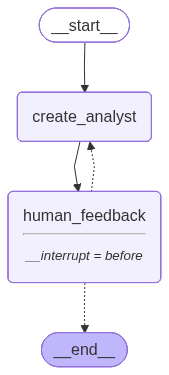

In [19]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [20]:
topic = "the benefits of adopting Langgraph as an agent framework"

In [21]:
max_analysts = 4

In [22]:
thread =  {"configurable":{"thread_id":1}}

In [23]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  
            
        

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Affiliation: Institute of Advanced AI Systems
Role: AI Framework Researcher
Description: Dr. Chen focuses on the comparative analysis of AI frameworks, with a particular interest in how Langgraph enhances agent-based systems. Her research delves into the technical benefits such as modularity, scalability, and ease of integration with existing systems. She is motivated by the potential of Langgraph to streamline AI development processes and improve system performance.
--------------------------------------------------
Name: Michael O'Neill
Affiliation: Tech Solutions Inc.
Role: Enterprise Technology Consultant
Description: Michael advises large enterprises on adopting new technologies. He is interested in how Langgraph can be leveraged to improve business operations and decision-making processes. His focus is on the practical benefits of Langgraph, such as reducing development time and costs, and enhancing the flexibility of AI solutions in dynamic business environm

The above step has create the subject expert analysts through LLM

In [24]:
analyst

Analyst(name='Raj Patel', role='Software Development Lead', affiliation='Innovatech Labs', description='Raj leads a team of developers working on cutting-edge AI projects. He is interested in the practical implementation of Langgraph in software development, focusing on its impact on team productivity and innovation. Raj is motivated by the potential of Langgraph to simplify complex AI development tasks and foster a more collaborative development environment.')

#### 2. Research Functionality

2.2 Initialize Tools
- TaVILY
- Wikipedia

In [25]:
# depricated
from langchain_community.tools.tavily_search import TavilySearchResults

from langchain_tavily import TavilySearch

In [26]:
from dotenv import load_dotenv
load_dotenv()
import os
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [27]:
tavily_search = TavilySearch(tavily_api_key=tavily_api_key)

In [28]:
tavily_search.invoke("langgraph")

{'query': 'langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ibm.com/think/topics/langgraph',
   'title': 'What is LangGraph?',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. **Nodes**: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by modeling complex rel

In [29]:
from langchain_community.document_loaders import WikipediaLoader
import wikipedia
wikipedia.set_user_agent("MyApp/1.0 (https://example.com)")

wikipedia.set_user_agent("Mozilla/5.0")
docs = WikipediaLoader(query="HUNTER X HUNTER",load_max_docs=1).load()
print(docs[0].page_content[:100])


Hunter × Hunter (pronounced "hunter hunter") is a Japanese manga series written and illustrated by Y


In [30]:
from langchain_community.utilities import WikipediaAPIWrapper
wikipedia.set_user_agent("MyApp/1.0 (https://example.com)")

wikipedia.set_user_agent("Mozilla/5.0")

wiki = WikipediaAPIWrapper(doc_content_chars_max=4000)
docs = wiki.run("The benefits of adopting LangGraph as an agentic framework")
print(docs)

Page: Semantic Web
Summary: The Semantic Web, sometimes known as Web 3.0, is an extension of the World Wide Web through standards set by the World Wide Web Consortium (W3C). The goal of the Semantic Web is to make Internet data machine-readable.
To enable the encoding of semantics with the data, technologies such as Resource Description Framework (RDF) and Web Ontology Language (OWL) are used. These technologies are used to formally represent metadata. For example, ontology can describe concepts, relationships between entities, and categories of things. These embedded semantics offer significant advantages such as reasoning over data and operating with heterogeneous data sources.
These standards promote common data formats and exchange protocols on the Web, fundamentally the RDF. According to the W3C, "The Semantic Web provides a common framework that allows data to be shared and reused across application, enterprise, and community boundaries." The Semantic Web is therefore regarded as

2.2 State & Pydantic models

In [32]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

# state for interview graph, we will use this state to store the conversation history, source docs, and analyst information. We will also set a max number of turns to prevent infinite conversations.
class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

#Pydantic model for search query validation
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

2.3 Prompt

In [33]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [34]:
analyst

Analyst(name='Raj Patel', role='Software Development Lead', affiliation='Innovatech Labs', description='Raj leads a team of developers working on cutting-edge AI projects. He is interested in the practical implementation of Langgraph in software development, focusing on its impact on team productivity and innovation. Raj is motivated by the potential of Langgraph to simplify complex AI development tasks and foster a more collaborative development environment.')

In [35]:
print(analyst.persona)

Name: Raj Patel
Role: Software Development Lead
Affiliation: Innovatech Labs
Description: Raj leads a team of developers working on cutting-edge AI projects. He is interested in the practical implementation of Langgraph in software development, focusing on its impact on team productivity and innovation. Raj is motivated by the potential of Langgraph to simplify complex AI development tasks and foster a more collaborative development environment.



In [36]:
question_instructions.format(goals = analyst.persona)

'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Raj Patel\nRole: Software Development Lead\nAffiliation: Innovatech Labs\nDescription: Raj leads a team of developers working on cutting-edge AI projects. He is interested in the practical implementation of Langgraph in software development, focusing on its impact on team productivity and innovation. Raj is motivated by the potential of Langgraph to simplify complex AI development tasks and foster a more collaborative development environment.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and ref

2.4 Create Functionalities

2.4.1 generation_question: generate the questions based on analyst role and descriptions

In [37]:
def generation_question(state:InterviewState):
    """Node to generate the questions"""
    
    #get state
    analyst = state["analyst"]
    messages = state["messages"]
    
    #generate the question
    system_message = question_instructions.format(goals = analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
    
    #returen the question through state
    return {"messages":[question]}

In [38]:
class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

In [39]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],"messages":[HumanMessage(content="hi do the proper search according to the experties")]}

In [40]:
state

{'max_num_turns': 2,
 'context': [],
 'analyst': Analyst(name='Raj Patel', role='Software Development Lead', affiliation='Innovatech Labs', description='Raj leads a team of developers working on cutting-edge AI projects. He is interested in the practical implementation of Langgraph in software development, focusing on its impact on team productivity and innovation. Raj is motivated by the potential of Langgraph to simplify complex AI development tasks and foster a more collaborative development environment.'),
 'interview': '',
 'section': [],
 'messages': [HumanMessage(content='hi do the proper search according to the experties', additional_kwargs={}, response_metadata={})]}

In [41]:
result = generation_question(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [42]:
result

{'messages': [AIMessage(content="Hello Raj, my name is Alex, and I'm an analyst interested in understanding the practical implementation of Langgraph in software development. I’m particularly curious about its impact on team productivity and innovation. Could you start by explaining what Langgraph is and how it differs from other AI development tools?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 250, 'total_tokens': 307, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ed36a96f3d', 'id': 'chatcmpl-D9Qc1LKEvTx8BIDYzl2kEP3TQBjPH', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--0123142d-bc55-4b9b-b880-6e06380b3e4f-0', usage_metadata={'input_tokens': 250, 'output_tokens': 5

In [43]:
print(result["messages"][0].content)

Hello Raj, my name is Alex, and I'm an analyst interested in understanding the practical implementation of Langgraph in software development. I’m particularly curious about its impact on team productivity and innovation. Could you start by explaining what Langgraph is and how it differs from other AI development tools?


##### 2.4.2 search_web: search the answers on Tavily

In [44]:
from langchain_core.messages import get_buffer_string

In [45]:
# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

In [46]:
def search_web(state:InterviewState):
    """
    Retrieve data from the web
    """
    structure_llm = llm.with_structured_output(SearchQuery)
    msgs = state.get("messages", [])
    if not isinstance(msgs, list):
        msgs = [msgs]
    search_query = structure_llm.invoke([search_instructions] + msgs)
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

    # Extract results list
    results = search_docs.get("results", [])

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc.get("url", "N/A")}"/>\n'
            f'{doc.get("content", "")}\n'
            f'</Document>'
            for doc in results
        ]
    )

    
    #return {"context": [formatted_search_docs]}
    return {"context": [formatted_search_docs] if formatted_search_docs else []}

    # formatted_search_docs = "\n\n---\n\n".join(
    #     [
    #         f'<Document href="{doc("url", "N/A")}"/>\n{doc("content", doc)}\n</Document>'
    #         for doc in search_docs
    #     ]
    # )
    # return {"context": formatted_search_docs}


In [47]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [48]:
result = search_web(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [49]:
result

{'context': ['<Document href="https://www.langchain.com/langgraph"/>\n[![Image 1](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/68e8e270df09334914882b88_Frame%209.svg) Observability Debug and monitor in-depth traces](https://www.langchain.com/langsmith/observability)[![Image 2](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/68e8e270f9e8de1d368764a8_Frame%20206.svg) Evaluation Iterate on prompts and models](https://www.langchain.com/langsmith/evaluation)[![Image 3](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/68e8e2709eef27fc61465416_Frame%20100039.svg) Deployment Ship and scale agents in production](https://www.langchain.com/langsmith/deployment)[![Image 4](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/692e7522b3ef627cb0ec1155_Centralized%20management.svg) Agent Builder New Build no-code agents](https://www.langchain.com/langsmith/agent-builder). [![Image 5](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/68e8e27023585

In [50]:
print(result["context"])

['<Document href="https://www.langchain.com/langgraph"/>\n[![Image 1](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/68e8e270df09334914882b88_Frame%209.svg) Observability Debug and monitor in-depth traces](https://www.langchain.com/langsmith/observability)[![Image 2](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/68e8e270f9e8de1d368764a8_Frame%20206.svg) Evaluation Iterate on prompts and models](https://www.langchain.com/langsmith/evaluation)[![Image 3](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/68e8e2709eef27fc61465416_Frame%20100039.svg) Deployment Ship and scale agents in production](https://www.langchain.com/langsmith/deployment)[![Image 4](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/692e7522b3ef627cb0ec1155_Centralized%20management.svg) Agent Builder New Build no-code agents](https://www.langchain.com/langsmith/agent-builder). [![Image 5](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/68e8e27023585643370a6471_

##### 2.4.3 search_wikipedia: search the answers on Wikipedia

converted logic to use duckduckgo search as it was was not functional

In [ ]:
from langchain_community.tools import DuckDuckGoSearchResults
search = DuckDuckGoSearchResults(output_format="list")

result = search.invoke("Langgraph framework benefits for business innovation and digital transformation")

Error in engine grokipedia: DDGSException("ConnectionError: ConnectionError('Connection error for URL: https://wt.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Langgraph%20framework%20benefits%20for%20business%20innovation%20and%20digital%20transformation', 'https://wt.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Langgraph%20framework%20benefits%20for%20business%20innovation%20and%20digital%20transformation')")


In [ ]:
result

[{'snippet': 'Digital transformation (DT) is the process of adoption and implementation of digital technology by an organization in order to create new or modify existing products, services and operations by the means of translating business processes into a digital format.',
  'title': 'Digital transformation - Wikipedia',
  'link': 'https://en.wikipedia.org/wiki/Digital_transformation'},
 {'snippet': "Bridge user expectations and agent capabilities with native token-by-token streaming and streaming of intermediate steps, helpful for showing agent reasoning and actions back to the user as they happen. Use LangGraph Platform's API to deliver dynamic and interactive user experiences.",
  'title': 'LangGraph : Agent Orchestration Framework for Reliable AI Agents',
  'link': 'https://www.langchain.com/langgraph'},
 {'snippet': 'So, how do you determine which one is right for your project? In this article, we’ll break down the differences between LangChain and LangGraph . We’ll also show h

In [ ]:
for doc in result:
    print(f'<Document source="{doc.get("link", "N/A")}"/>\n{doc.get("snippet", "N/A")}\n</Document>')


<Document source="https://en.wikipedia.org/wiki/Digital_transformation"/>
Digital transformation (DT) is the process of adoption and implementation of digital technology by an organization in order to create new or modify existing products, services and operations by the means of translating business processes into a digital format.
</Document>
<Document source="https://www.langchain.com/langgraph"/>
Bridge user expectations and agent capabilities with native token-by-token streaming and streaming of intermediate steps, helpful for showing agent reasoning and actions back to the user as they happen. Use LangGraph Platform's API to deliver dynamic and interactive user experiences.
</Document>
<Document source="https://www.curotec.com/insights/langchain-vs-langgraph-framework-comparison/"/>
So, how do you determine which one is right for your project? In this article, we’ll break down the differences between LangChain and LangGraph . We’ll also show how they can work together to give you

In [78]:
import wikipedia
from langchain_community.tools import DuckDuckGoSearchResults

def search_wikipedia(state:InterviewState):
    """
    Retrieve data from wiki
    """

    #wikipedia.set_user_agent("MyApp/1.0 (https://example.com)")
    #wikipedia.set_user_agent("Mozilla/5.0")

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    print("*******************************")
    print(search_query)
    
    # Search
    #search_docs = WikipediaLoader(query=search_query.search_query).load()
    search = DuckDuckGoSearchResults(output_format="list")
    search_docs = search.invoke(search_query.search_query)

    # Format
    # formatted_search_docs = "\n\n---\n\n".join(
    #     [
    #         f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
    #         for doc in search_docs
    #     ]
    # )

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.get("link", "N/A")}"/>\n{doc.get("snippet", "N/A")}\n</Document>'
            for doc in search_docs
        ]
    )

    # #return {"context": [formatted_search_docs]} 
    return {"context": [formatted_search_docs] if formatted_search_docs else []}
    return search_query

    

In [79]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [80]:
result = search_wikipedia(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langgraph framework benefits for business innovation and digital transformation'


Error in engine grokipedia: DDGSException("ConnectionError: ConnectionError('Connection error for URL: https://wt.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Langgraph%20framework%20benefits%20for%20business%20innovation%20and%20digital%20transformation', 'https://wt.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Langgraph%20framework%20benefits%20for%20business%20innovation%20and%20digital%20transformation')")


In [64]:
search_docs = WikipediaLoader(query='Langgraph framework benefits for business innovation and digital transformation').load()

In [65]:
search_docs

[]

In [81]:
result

{'context': ['<Document source="https://www.bing.com/aclick?ld=e8zh8JH2SltV5xFTJpsUK9wDVUCUxRp8NQGlPTNJIE09tdfI06NHbSjyCNBl4n_IfCB3t10UQgXoFCWNNvf472CB5qRQ7GRu5Jv1VZpmfiN6xnyvMj6atmBJlHi3S_0nhscyrLkji5KoyGmRcQW1zonfw_3oZTO9N7EtV5gVWWUZN_E_1bGbIR0GHo8-wm0o2IwnM5RVMAfeu8PVRVjFG6tJzgZlM&u=aHR0cHMlM2ElMmYlMmZhZC5kb3VibGVjbGljay5uZXQlMmZzZWFyY2hhZHMlMmZsaW5rJTJmY2xpY2slM2ZsaWQlM2Q0MzcwMDA4MzAwOTk1MDUxMSUyNmRzX3Nfa3dnaWQlM2Q1ODcwMDAwODk4NDU0Njk5MSUyNmRzX2FfY2lkJTNkNzY1Njc4MTEzNyUyNmRzX2FfY2FpZCUzZDIzMzM1NDQwOTQzJTI2ZHNfYV9hZ2lkJTNkMTg5NzM4NTcwNDM2JTI2ZHNfYV9saWQlM2Rrd2QtMzU2NjQxMDgyMzg5JTI2JTI2ZHNfZV9hZGlkJTNkNzcxNzIxOTYwNzMxOTQlMjZkc19lX3RhcmdldF9pZCUzZGt3ZC03NzE3MjQ5OTc3MjA2MCUzYWxvYy05MCUyNiUyNmRzX2VfbmV0d29yayUzZG8lMjZkc191cmxfdiUzZDIlMjZkc19kZXN0X3VybCUzZGh0dHBzJTNhJTJmJTJmd3d3LmV5LmNvbSUyZmVuX3VzJTJmY2lvJTNmV1QubWNfaWQlM2QxMDg2MzY5MyUyNkFBLnRzcmMlM2RwYWlkc2VhcmNoJTI2Z2NsaWQlM2Q5ZWI3MThlNjM5OWUxMjg2MDY4MTcxNzc0MGZmMDdmZiUyNmdjbHNyYyUzZDNwLmRzJTI2JTI2bXNjbGtpZCUzZDllYjcxOGU2Mzk5ZTEyODYwN

##### 2.4.4 generate_answer: 

In [82]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [83]:
def generate_answer(state:InterviewState):
   
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}
    

how many analyst we were doing to be create:
4

max_trun:2

means if atleast 2 expert are giving ans then we can save the result.

##### 2.4.5 route_messages:

In [84]:
def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    
    return "ask_question"

##### 2.4.5 save_interview:

In [85]:
def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

In [86]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

##### 2.4.5 write_section:

In [87]:
def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}


In [88]:
interview_builder = StateGraph(InterviewState)

In [89]:
interview_builder.add_node("ask_question",generation_question)
interview_builder.add_node("search_web",search_web)
interview_builder.add_node("search_wikipedia",search_wikipedia)
interview_builder.add_node("generate_answer",generate_answer)
interview_builder.add_node("save_interview",save_interview)
interview_builder.add_node("write_section",write_section)

In [90]:
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question","search_web")
interview_builder.add_edge("ask_question","search_wikipedia")
interview_builder.add_edge("search_web","generate_answer")
interview_builder.add_edge("search_wikipedia","generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                           route_messages,
                           ["ask_question",
                            "save_interview"])
interview_builder.add_edge("save_interview","write_section")
interview_builder.add_edge("write_section",END)

In [91]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name = "Conduct Interview")


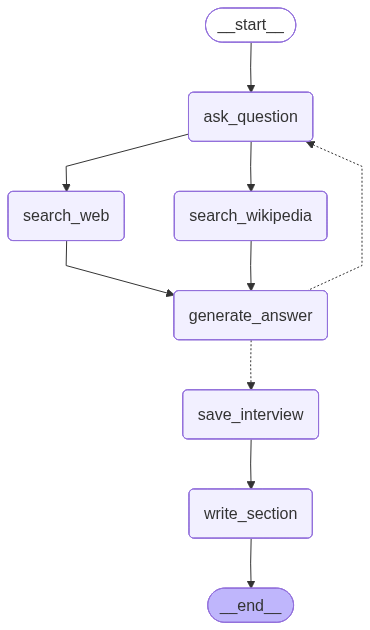

In [92]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [93]:
analyst

Analyst(name='Raj Patel', role='Software Development Lead', affiliation='Innovatech Labs', description='Raj leads a team of developers working on cutting-edge AI projects. He is interested in the practical implementation of Langgraph in software development, focusing on its impact on team productivity and innovation. Raj is motivated by the potential of Langgraph to simplify complex AI development tasks and foster a more collaborative development environment.')

In [94]:
analyst.persona

'Name: Raj Patel\nRole: Software Development Lead\nAffiliation: Innovatech Labs\nDescription: Raj leads a team of developers working on cutting-edge AI projects. He is interested in the practical implementation of Langgraph in software development, focusing on its impact on team productivity and innovation. Raj is motivated by the potential of Langgraph to simplify complex AI development tasks and foster a more collaborative development environment.\n'

In [95]:
thread = {"configurable": {"thread_id": "1"}}

In [96]:
from IPython.display import Markdown

In [97]:
#messages = [HumanMessage("So you said you were writing an article on Langchain?")]
messages = [HumanMessage("So you said you were writing an article on Langchain?")]

In [98]:
interview = interview_graph.invoke({"analyst": analyst, "messages": messages, "max_num_turns": 2}, thread)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langgraph implementation impact on software development teams productivity and innovation'


Error in engine grokipedia: DDGSException("ConnectionError: ConnectionError('Connection error for URL: https://wt.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Langgraph%20implementation%20impact%20on%20software%20development%20teams%20productivity%20and%20innovation', 'https://wt.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Langgraph%20implementation%20impact%20on%20software%20development%20teams%20productivity%20and%20innovation')")
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langgraph impact on AI development productivity Innovatech Labs'


Error in engine grokipedia: DDGSException("ConnectionError: ConnectionError('Connection error for URL: https://wt.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Langgraph%20impact%20on%20AI%20development%20productivity%20Innovatech%20Labs', 'https://wt.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Langgraph%20impact%20on%20AI%20development%20productivity%20Innovatech%20Labs')")
Error in engine duckduckgo: AttributeError("module 'httpcore._sync' has no attribute 'http2'")
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [99]:
Markdown(interview['sections'][0])

## LangGraph: Revolutionizing AI Development for Enhanced Productivity and Innovation

### Summary

In the rapidly evolving landscape of AI development, LangGraph emerges as a transformative framework that promises to enhance team productivity and foster innovation. As Raj and his team of developers explore cutting-edge AI projects, LangGraph offers a practical solution for simplifying complex AI development tasks and creating a collaborative environment. Unlike traditional frameworks, LangGraph is designed to handle the intricacies of production-scale systems, making it an ideal choice for developers aiming to build robust, multi-agent applications.

LangGraph's novel approach lies in its graph-based architecture, which allows for the modeling and management of complex relationships within AI workflows. This architecture supports the creation of stateful, multi-agent systems that can adapt and learn from interactions, a feature often lacking in traditional directed acyclic graph (DAG) frameworks [1]. By enabling cycles within graphical structures, LangGraph facilitates dynamic exchanges and decision-making processes, which are crucial for real-world applications [2].

One of the most interesting aspects of LangGraph is its ability to integrate with various tools and services, providing developers with the flexibility to customize and extend their frameworks to meet specific needs. This integration capability not only simplifies the development process but also fosters community-driven innovation by lowering barriers to entry for smaller teams [3]. LangGraph's open-source nature further enhances its appeal, allowing developers to build reliable, production-ready AI systems with ease [4].

LangGraph's impact on team productivity is evident in its ability to streamline workflows and improve collaboration. The framework's state management features ensure that AI agents can operate efficiently, reducing the time and effort required to manage complex tasks. For instance, LangGraph's state-machine approach has been instrumental in building mission-critical applications, providing developers with a dependable solution for AI agent deployment [5].

Moreover, LangGraph's role as a "team manager" and "project planner" for AI agents highlights its potential to foster a more collaborative development environment. By orchestrating agent interactions and managing memory, LangGraph enables teams to move beyond the limitations of single-turn prompts and embrace the complexities of multi-agent workflows [6]. This capability is particularly beneficial for businesses seeking to automate processes and enhance their AI-driven solutions.

In summary, LangGraph stands out as a powerful tool for AI development, offering a robust framework that enhances productivity and innovation. Its graph-based architecture, integration capabilities, and focus on state management make it an invaluable asset for developers like Raj, who are committed to pushing the boundaries of AI technology.

### Sources
[1] https://www.oreateai.com/blog/unlocking-the-power-of-langgraph-a-new-era-for-ai-development/aaa5f01ba632052c79a64b6d10e85d04  
[2] https://www.tribe.ai/applied-ai/unlocking-the-magic-of-agentic-frameworks-building-collaborative-ai-teams-with-langgraph  
[3] https://blog.premai.io/open-source-agentic-frameworks-langgraph-vs-crewai-more/  
[4] https://www.ibm.com/think/topics/langgraph  
[5] https://medium.com/@vikaskumarsingh_60821/langgraph-the-future-of-production-grade-ai-agent-architectures-623d68dbbfb6  
[6] https://www.scalablepath.com/machine-learning/langgraph  

## 3. GENERATE WORKFLOW

##### 3.1 State

In [ ]:
from typing_extensions import TypedDict
from typing import List, Annotated
import operator

# a dictionary object to hold the state of the research graph, which includes the research topic, number of analysts, human feedback, list of analysts, source documents, and sections of the final report. We will use this state to track the progress of our research and analysis process.

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report
    
# class InterviewState(MessagesState):
#     max_num_turns: int # Number turns of conversation
#     context: Annotated[list, operator.add] # Source docs
#     analyst: Analyst # Analyst asking questions
#     interview: str # Interview transcript
#     sections: list # Final key we duplicate in outer state for Send() API

##### 3.2 Initiate all interviews

In [100]:
from langgraph.types import Send


In [104]:
# This method will run all the interviews inparallel with all the agents
def initiate_all_interviews(state:ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """ 
    
    #check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"
    
    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                        "messages": [HumanMessage(
                                            content=f"So you said you were writing an article on {topic}?"
                                        )
                                                ]}) for analyst in state["analysts"]]

##### 3.3 Write the report


In [102]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

In [105]:
def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

##### 3.4 Write the introduction

In [106]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

In [107]:
def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

##### 3.5 Write the conclusion


In [ ]:
def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

##### 3.6 Finalize report


In [ ]:
def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

##### 3.7 Research Workflow


In [ ]:
# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analyst)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)